In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from mindreadingautobots.sequence_generators import make_datasets, data_io
from mindreadingautobots.entropy_and_bayesian import entropy
import time

import gspread
from google.oauth2.service_account import Credentials


In [2]:
# Path to your service account JSON file
SERVICE_ACCOUNT_FILE = "../velvety-tube-450516-r5-2dfa430c056c.json" 


# Define the scope (Google Sheets + Google Drive API)
SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive.file",  # Allows access to files the service account has access to
    "https://www.googleapis.com/auth/drive.readonly"  # Read-only access to drive files
]
# Authenticate with Google
creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
client = gspread.authorize(creds)

# Open the spreadsheet
SPREADSHEET_NAME = "sparse_majority_41_5"
spreadsheet = client.open(SPREADSHEET_NAME)

# Get names of all sheets
sheet_names = [sheet.title for sheet in spreadsheet.worksheets()]
name_to_idx = {}
for i, name in enumerate(sheet_names):
    name_to_idx[name] = i
    

In [3]:
# Get names of all sheets
sheet_names = [sheet.title for sheet in spreadsheet.worksheets()]
name_to_idx = {}
for i, name in enumerate(sheet_names):
    name_to_idx[name] = i
print("Sheets in the spreadsheet:")
for name in sheet_names:
    print(f"  {name}")

Sheets in the spreadsheet:
  SAN_sparse_majority_k5_nbits41_n2000_bf10_seed1234
  RNN_sparse_majority_k5_nbits41_n2000_bf0_seed1234
  SAN_sparse_majority_k5_nbits41_n2000_bf0_seed1234
  SAN_sparse_majority_k5_nbits41_n2000_bf45_seed1234
  RNN_sparse_majority_k5_nbits41_n2000_bf15_seed1234
  RNN_sparse_majority_k5_nbits41_n2000_bf40_seed1234
  RNN_sparse_majority_k5_nbits41_n2000_bf25_seed1234
  RNN_sparse_majority_k5_nbits41_n2000_bf30_seed1234
  RNN_sparse_majority_k5_nbits41_n2000_bf35_seed1234
  SAN_sparse_majority_k5_nbits41_n2000_bf40_seed1234
  SAN_sparse_majority_k5_nbits41_n2000_bf35_seed1234
  SAN_sparse_majority_k5_nbits41_n2000_bf30_seed1234
  SAN_sparse_majority_k5_nbits41_n2000_bf25_seed1234
  SAN_sparse_majority_k5_nbits41_n2000_bf15_seed1234
  RNN_sparse_majority_k5_nbits41_n2000_bf5_seed1234
  SAN_sparse_majority_k5_nbits41_n2000_bf5_seed1234
  RNN_sparse_majority_k5_nbits41_n2000_bf10_seed1234
  RNN_sparse_majority_k5_nbits41_n2000_bf20_seed1234
  RNN_sparse_majority_k

In [70]:
bf_vals = list(range(0, 50, 5))
best_n = 1
assert best_n == 1
df_dct = {
    "RNN": {}, 
    "SAN": {}
            }

best_dct = {
    "RNN": {"noiseless": [], "noisy": [], "train_acc": []}, 
    "SAN": {"noiseless": [], "noisy": [], "train_acc": []}
            }

for k in best_dct.keys():
    sheetname_template = '{}_sparse_majority_k5_nbits41_n2000_bf{}_seed1234'
    for bf in bf_vals:
        target = sheetname_template.format(k, bf)
        target_idx = name_to_idx.get(target)
        print("Loading:", target)
        sheet = spreadsheet.get_worksheet(target_idx)
        data = sheet.get_all_records()

        df = pd.DataFrame(data)
        df_dct[k][bf] = df
        best_noiseless = df.sort_values(by='val_acc', ascending=False).head(best_n)['noiseless_val_acc'].to_numpy()
        best_training = df.sort_values(by='val_acc', ascending=False).head(best_n)['train_acc'].to_numpy()

        best_noisy = df.sort_values(by='val_acc', ascending=False).head(best_n)['val_acc'].to_numpy()
        best_dct[k]["noiseless"].append(best_noiseless)
        best_dct[k]["noisy"].append(best_noisy)
        best_dct[k]["train_acc"].append(best_training)


Loading: RNN_sparse_majority_k5_nbits41_n2000_bf0_seed1234
Loading: RNN_sparse_majority_k5_nbits41_n2000_bf5_seed1234
Loading: RNN_sparse_majority_k5_nbits41_n2000_bf10_seed1234
Loading: RNN_sparse_majority_k5_nbits41_n2000_bf15_seed1234
Loading: RNN_sparse_majority_k5_nbits41_n2000_bf20_seed1234
Loading: RNN_sparse_majority_k5_nbits41_n2000_bf25_seed1234
Loading: RNN_sparse_majority_k5_nbits41_n2000_bf30_seed1234
Loading: RNN_sparse_majority_k5_nbits41_n2000_bf35_seed1234
Loading: RNN_sparse_majority_k5_nbits41_n2000_bf40_seed1234
Loading: RNN_sparse_majority_k5_nbits41_n2000_bf45_seed1234
Loading: SAN_sparse_majority_k5_nbits41_n2000_bf0_seed1234
Loading: SAN_sparse_majority_k5_nbits41_n2000_bf5_seed1234
Loading: SAN_sparse_majority_k5_nbits41_n2000_bf10_seed1234
Loading: SAN_sparse_majority_k5_nbits41_n2000_bf15_seed1234
Loading: SAN_sparse_majority_k5_nbits41_n2000_bf20_seed1234
Loading: SAN_sparse_majority_k5_nbits41_n2000_bf25_seed1234
Loading: SAN_sparse_majority_k5_nbits41_n200

In [66]:

X_true, Z_true, idx = sparse_majority_k5(n_data=2000, n_bits=21, p_bitflip=0.3, seed=1234, subseq_idx=[ 3, 13,  2, 16, 14])
_, _, train_lookup = entropy.empirical_entropy_estimate(Z_true)
mle_train = entropy.compute_mle_with_lookup(Z_true, train_lookup[-1])

In [67]:
for z in Z_true:
    true = z[-1]
    lookup = train_lookup[-1].get(tuple(z)[:-1])
    if true != lookup:
        print(z, true, lookup)


[0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0] 0 1


In [39]:

all_H = []
all_mle = []
p_bitflips = [bf / 100 for bf in bf_vals]
def sparse_majority_k5(n_data, n_bits, p_bitflip, seed, subseq_idx=None):
    return make_datasets.sparse_majority_k_n(n_bits, 5, n_data, p_bitflip, seed, subseq_idx=subseq_idx)

# Generate data with bitflip values
seed = 1234 
n_data = 100000 # ~maximum~ amount of data to analyze
inc = 50000 # increment at which to check convergence
assert inc < n_data
n_bits = 6 # HACK: We only consider the bits that actually contribute to the majority vote
intermediate_idx = list(range(inc, n_data, inc))

all_H = []
all_mle_noisy = []
all_mle_noiseless = []
all_mle_train = []

for i in range(len(p_bitflips)):

    t0 = time.time()
    X, Z, idx = sparse_majority_k5(n_data, n_bits, p_bitflips[i], seed)
    print("generated data for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    t0 = time.time()
    # compute the mle performance and the mle lookup table for this dataset
    H_results, mle_results, lookup_results = entropy.empirical_entropy_estimate(Z, intermediate_idx=intermediate_idx)
    print("computed entropy for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    all_H.append(H_results)
    all_mle_noisy.append(mle_results)
    # compute the accuracy of MLE(trained on noisy) predicting the noiseless data
    t0 = time.time()
    mle_noiseless = entropy.compute_mle_with_lookup(X, lookup_results[-1])
    print("computed noiseless MLE for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    all_mle_noiseless.append(mle_noiseless)
    
    # compute the maximum possible training accuracy on this specific dataset
    _, Z_true, idx = sparse_majority_k5(n_data=2000, n_bits=21, p_bitflip=p_bitflips[i], seed=1234, subseq_idx=[ 3, 13,  2, 16, 14])
    _, _, train_lookup = entropy.empirical_entropy_estimate(Z_true, intermediate_idx=[2000])
    mle_train = entropy.compute_mle_with_lookup(Z_true, train_lookup[-1])
    all_mle_train.append(mle_train)

generated data for p_bitflip =  0.0  took  0.5926587581634521  seconds
computed entropy for p_bitflip =  0.0  took  0.12213253974914551  seconds
computed noiseless MLE for p_bitflip =  0.0  took  0.2573254108428955  seconds
generated data for p_bitflip =  0.05  took  0.6280374526977539  seconds
computed entropy for p_bitflip =  0.05  took  0.1149449348449707  seconds
computed noiseless MLE for p_bitflip =  0.05  took  0.2375335693359375  seconds
generated data for p_bitflip =  0.1  took  0.7494430541992188  seconds
computed entropy for p_bitflip =  0.1  took  0.11560797691345215  seconds
computed noiseless MLE for p_bitflip =  0.1  took  0.2200758457183838  seconds
generated data for p_bitflip =  0.15  took  0.565155029296875  seconds
computed entropy for p_bitflip =  0.15  took  0.10900187492370605  seconds
computed noiseless MLE for p_bitflip =  0.15  took  0.23021221160888672  seconds
generated data for p_bitflip =  0.2  took  0.5650537014007568  seconds
computed entropy for p_bitfl

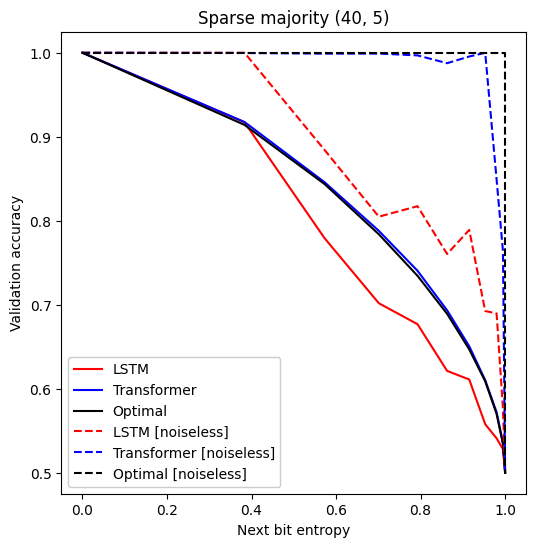

In [79]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
def append_last(x, y):
    # return (x, y)
    return np.concatenate((x, [1])).flatten(), np.concatenate((y, [0.5])).flatten()

xvals = np.array([x[-1] for x in all_H])
mle_noisy_final = np.array([x[-1] for x in all_mle_noisy])
# xvals = p_bitflips

rnn_noiseless = np.array(best_dct["RNN"]["noiseless"]).flatten()
rnn_noisy = np.array(best_dct["RNN"]["noisy"]).flatten()
san_noiseless = np.array(best_dct["SAN"]["noiseless"]).flatten()
san_noisy = np.array(best_dct["SAN"]["noisy"]).flatten()

axes.plot(*append_last(xvals, rnn_noisy), label='LSTM', c='r', ls='-')
axes.plot(*append_last(xvals, san_noisy), label='Transformer', c='b', ls='-')
axes.plot(*append_last(xvals, mle_noisy_final), label='Optimal', c='k', ls='-')

axes.plot(*append_last(xvals, rnn_noiseless), label='LSTM [noiseless]', c='r', ls='--')
axes.plot(*append_last(xvals, san_noiseless), label='Transformer [noiseless]', c='b', ls='--')
axes.plot([0, 1, 1], [1, 1, 0.5], label='Optimal [noiseless]', c='k', ls='--')


# plot the noiseless mle by hand

leg_prop = {'size': 10}
axes.legend(prop=leg_prop, framealpha=1)
axes.set_title("Sparse majority (40, 5)")
axes.set_xlabel('Next bit entropy')
axes.set_ylabel('Validation accuracy')
print()
# for p in xvals:
#     axes.axvline(p, c='k', alpha=0.1)
# axes.plot(np.repeat(bf_vals, best_n), best_dct["RNN"].flatten(), axis=1, label='RNN')
# axes.plot(np.repeat(bf_vals, best_n), best_dct["SAN"].flatten(), axis=1, label='SAN')

In [81]:
from math import comb
p = 0.4
print("probability of no error = ", (1-p)**5)
print("probability of 1 error = ", 5*p*(1-p)**4)
print("probability of 2 errors = ", 10*p**2*(1-p)**3)

probability of no error =  0.07775999999999998
probability of 1 error =  0.2592
probability of 2 errors =  0.3456


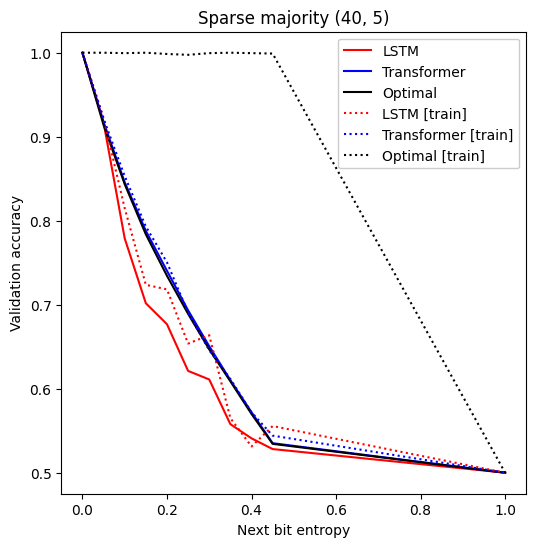

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
def append_last(x, y):
    # return (x, y)
    return np.concatenate((x, [1])).flatten(), np.concatenate((y, [0.5])).flatten()

xvals = np.array([x[-1] for x in all_H])
# xvals = p_bitflips

rnn_noiseless = np.array(best_dct["RNN"]["noiseless"]).flatten()
rnn_noisy = np.array(best_dct["RNN"]["noisy"]).flatten()
rnn_train = np.array(best_dct["RNN"]["train_acc"]).flatten()
san_noiseless = np.array(best_dct["SAN"]["noiseless"]).flatten()
san_noisy = np.array(best_dct["SAN"]["noisy"]).flatten()
san_train = np.array(best_dct["SAN"]["train_acc"]).flatten()

axes.plot(*append_last(xvals, rnn_noisy), label='LSTM', c='r', ls='-')
axes.plot(*append_last(xvals, san_noisy), label='Transformer', c='b', ls='-')

axes.plot(*append_last(xvals, mle_noisy_final), label='Optimal', c='k', ls='-')

mle_train_final = np.array(all_mle_train)

axes.plot(*append_last(xvals, rnn_train), label='LSTM [train]', c='r', ls=':')
axes.plot(*append_last(xvals, san_train), label='Transformer [train]', c='b', ls=':')

axes.plot(*append_last(xvals, mle_train_final), label='Optimal [train]', c='k', ls=':')


# plot the noiseless mle by hand

leg_prop = {'size': 10}
axes.legend(prop=leg_prop, framealpha=1)
axes.set_title("Sparse majority (40, 5)")
axes.set_xlabel('Next bit entropy')
axes.set_ylabel('Validation accuracy')
print()
# for p in xvals:
#     axes.axvline(p, c='k', alpha=0.1)
# axes.plot(np.repeat(bf_vals, best_n), best_dct["RNN"].flatten(), axis=1, label='RNN')
# axes.plot(np.repeat(bf_vals, best_n), best_dct["SAN"].flatten(), axis=1, label='SAN')

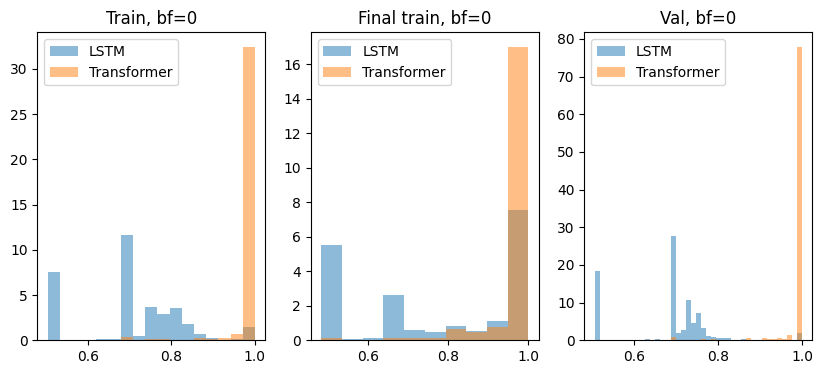

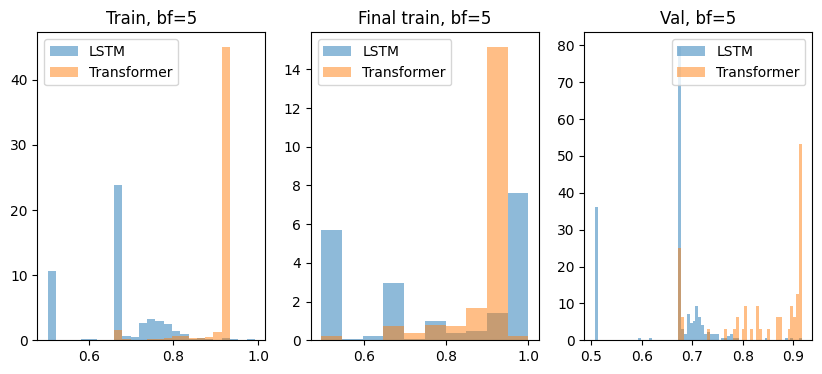

c:\Users\peter\Desktop\projects\MindReadingAutobot\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


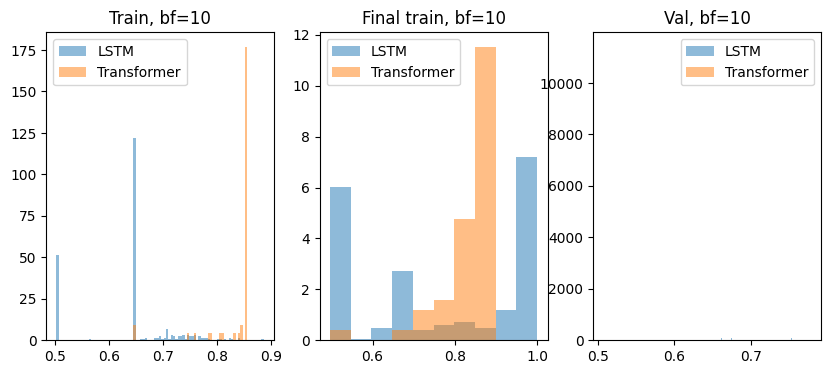

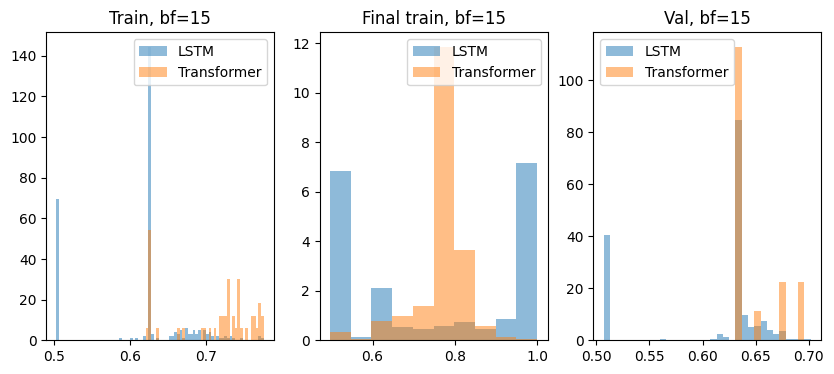

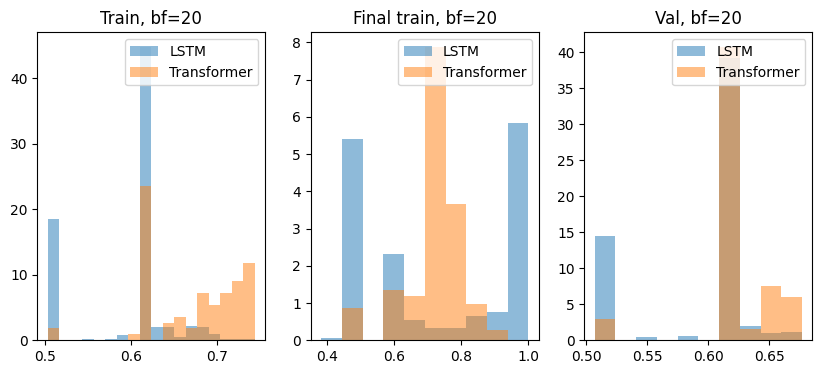

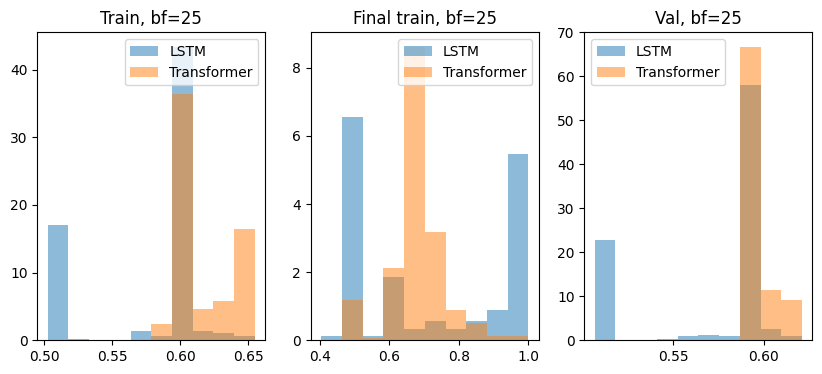

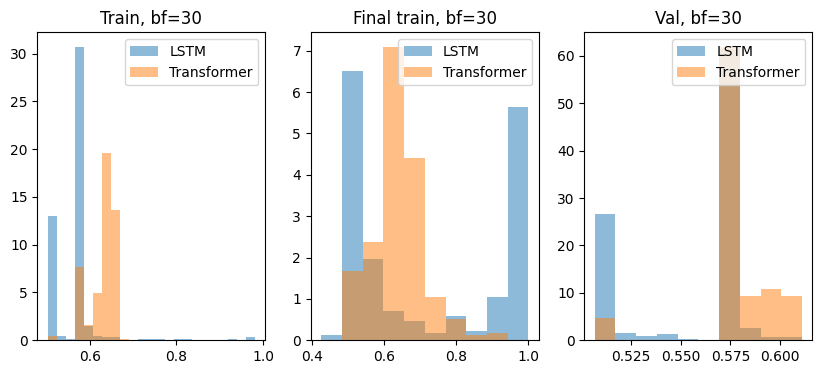

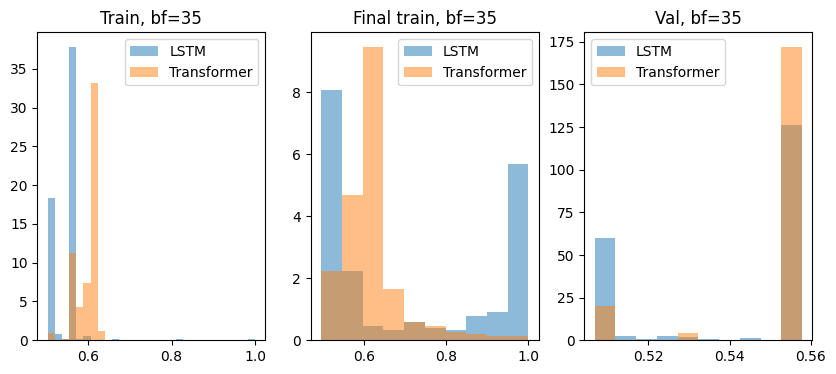

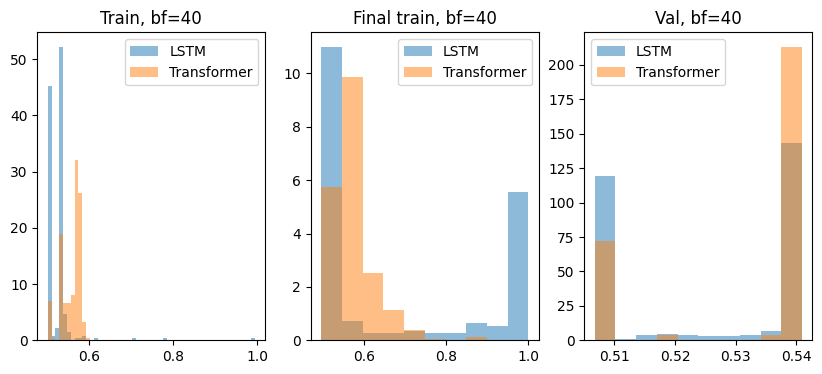

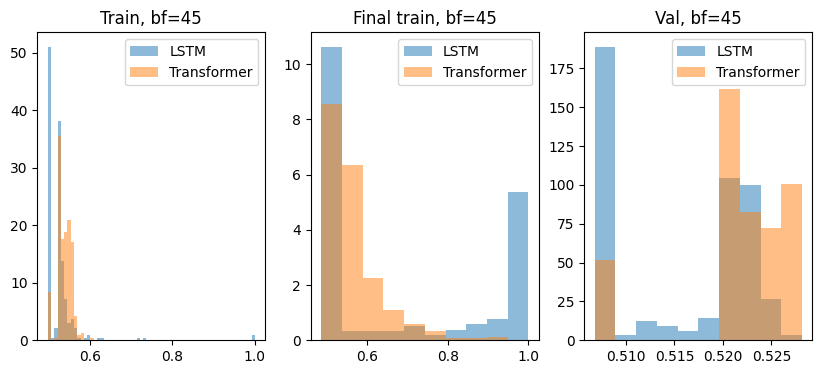

In [77]:
plt.close('all')

for i, bf in enumerate(bf_vals):
    rnn_df = df_dct["RNN"][bf]
    san_df = df_dct["SAN"][bf]
    # histogram of training accuracies
    train_acc_rnn = rnn_df['train_acc']
    train_acc_san = san_df['train_acc']
    final_train_acc_rnn = rnn_df['final_train_acc']
    final_train_acc_san = san_df['final_train_acc']
    val_acc_rnn = rnn_df['val_acc']
    val_acc_san = san_df['val_acc']
    gen_gap_rnn =  train_acc_rnn - val_acc_rnn
    gen_gap_san =  train_acc_san - val_acc_san

    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    density = True
    cts, bins, _ = axes[0].hist(train_acc_rnn, bins='auto', alpha=0.5, label='LSTM', density=density)
    axes[0].hist(train_acc_san, bins=bins, alpha=0.5, label='Transformer', density=density)
    axes[0].legend()
    axes[0].set_title(f"Train, bf={bf}")

    cts, bins, _ = axes[1].hist(final_train_acc_rnn, bins='auto', alpha=0.5, label='LSTM', density=density)
    axes[1].hist(final_train_acc_san, bins=bins, alpha=0.5, label='Transformer', density=density)
    axes[1].legend()
    axes[1].set_title(f"Final train, bf={bf}")

    cts, bins, _ = axes[2].hist(val_acc_rnn, bins='auto', alpha=0.5, label='LSTM', density=density)
    axes[2].hist(val_acc_san, bins=bins, alpha=0.5, label='Transformer', density=density)
    axes[2].set_title(f"Val, bf={bf}")
    axes[2].legend()